### EEGNet on windowed eeg dataset


This code is designed to train an SNN EEGNet network using Spiking Jelly library. The dataset contains clean eeg data (32 channels x 25 seconds) split in epoch of duration of 5 seconds with an overlap of 4 seconds.

In [1]:
from google.colab import drive
# mount the Google Drive files to Colab
drive.mount('/content/drive/')

#!ls drive/MyDrive/
import sys
import glob
sys.path.append('/content/drive/MyDrive/Thesis/')

PATH = "/content/drive/MyDrive/Thesis/snn_eegnet_model.pt"
HISTORY_PATH = "/content/drive/MyDrive/Thesis/snn_saved_dictionary.pkl"
FILES_PATH = glob.glob("/content/drive/MyDrive/eeg_dataset/filtered_data/*.mat")
LABELS_PATH = "/content/drive/MyDrive/eeg_dataset/scales.xls"
COORD_PATH = "/content/drive/MyDrive/eeg_dataset/Coordinates.xls"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# install required packages - for colab
!pip install autoreject
!pip install mne
!pip install spikingjelly
!pip install snntorch

In [3]:
# - Basic imports
import torch
import torchvision
import mne
import numpy as np
import os

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [9.6, 3.6]
plt.rcParams['font.size'] = 12

from tqdm.autonotebook import tqdm, trange
# - Import the SNN modules from rockpool

from utils_all_channels import EegData
from bsa import BSA
from poisson import poisson
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd

### Load dataset, split it in the tasks and create epochs

Initial eeg signal has 32 channels X 3200 samples(25 sec of recording with 128 samples per second (SPS)).

Split each signal in epochs of 5 duration sec: 32 channels x 640 samples (5 sec x 128 SPS).
Number of epochs: 40 subjects X 12 trials X 21 epochs = 2400 epochs.

Final dataset: 10080 epochs X 32 channels X 640 samples

In [4]:
# Read EEG data from the figshare dataset
print((FILES_PATH[0].split('/')))
#SOURCE_DIR = '/content/drive/My Drive/carseg_data/arrays'

arithmetic_task_files = [i for i in FILES_PATH if 'Arithmetic' in i.split('/')[6]]
mirror_image_task_files =[i for i in FILES_PATH if 'Mirror_image' in i.split('/')[6]]
relax_files = [i for i in FILES_PATH if 'Relax' in i.split('/')[6]]
stroop_task_files =  [i for i in FILES_PATH if 'Stroop' in i.split('/')[6]]

print(arithmetic_task_files)
# print(len(arithmetic_task_files), len(mirror_image_task_files), len(relax_files), len(stroop_task_files))
duration = 5
overlap = 3

arithmetic_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in arithmetic_task_files]
mirror_image_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in mirror_image_task_files]
relax_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in relax_files]
stroop_task_epochs = [EegData.from_mat_file(i, len_segments = duration, overlap=overlap, data_key="Clean_data").data for i in stroop_task_files]

data_list = arithmetic_task_epochs + mirror_image_task_epochs + relax_task_epochs + stroop_task_epochs
data_array = np.vstack(data_list)


['', 'content', 'drive', 'MyDrive', 'eeg_dataset', 'filtered_data', 'Arithmetic_sub_10_trial1.mat']
['/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial3.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_10_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_11_trial3.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_13_trial2.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_13_trial1.mat', '/content/drive/MyDrive/eeg_dataset/filtered_data/Arithmetic_sub_12_trial3.mat', '/conten

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matc

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matc

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matc

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matc

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 proje

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using d

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Ran

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad e

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not set

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creatin

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 11 events and 640 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Not setting metadata
11 matching events found
No base

/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return self._data.get_data()
/content/drive/MyDrive/Thesis/utils_all_channels.py:21: FutureWarning: The current default of copy=False

In [5]:
print(data_array.shape)
no_repeat = data_array.shape[0]/(12*40)
# no_repeat = (25 - duration) / (duration - overlap) + 1 (if 25 % duration != 0 or overlap != 0)
print(no_repeat)
print(len(data_list))
print(len(arithmetic_task_epochs), len(mirror_image_task_epochs), len(relax_task_epochs), len(stroop_task_epochs))

(5280, 32, 640)
11.0
480
120 120 120 120


##### Load labels and transform them to binary values ( feedback higher than 5: stressed, less than 5: relaxed)


array([[<Axes: title={'center': 'sub_'}>,
        <Axes: title={'center': 'Arithmetic_trial1'}>,
        <Axes: title={'center': 'Mirror_image_trial1'}>],
       [<Axes: title={'center': 'Stroop_trial1'}>,
        <Axes: title={'center': 'Arithmetic_trial2'}>,
        <Axes: title={'center': 'Mirror_image_trial2'}>],
       [<Axes: title={'center': 'Stroop_trial2'}>,
        <Axes: title={'center': 'Arithmetic_trial3'}>,
        <Axes: title={'center': 'Mirror_image_trial3'}>],
       [<Axes: title={'center': 'Stroop_trial3'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 2880x1080 with 0 Axes>

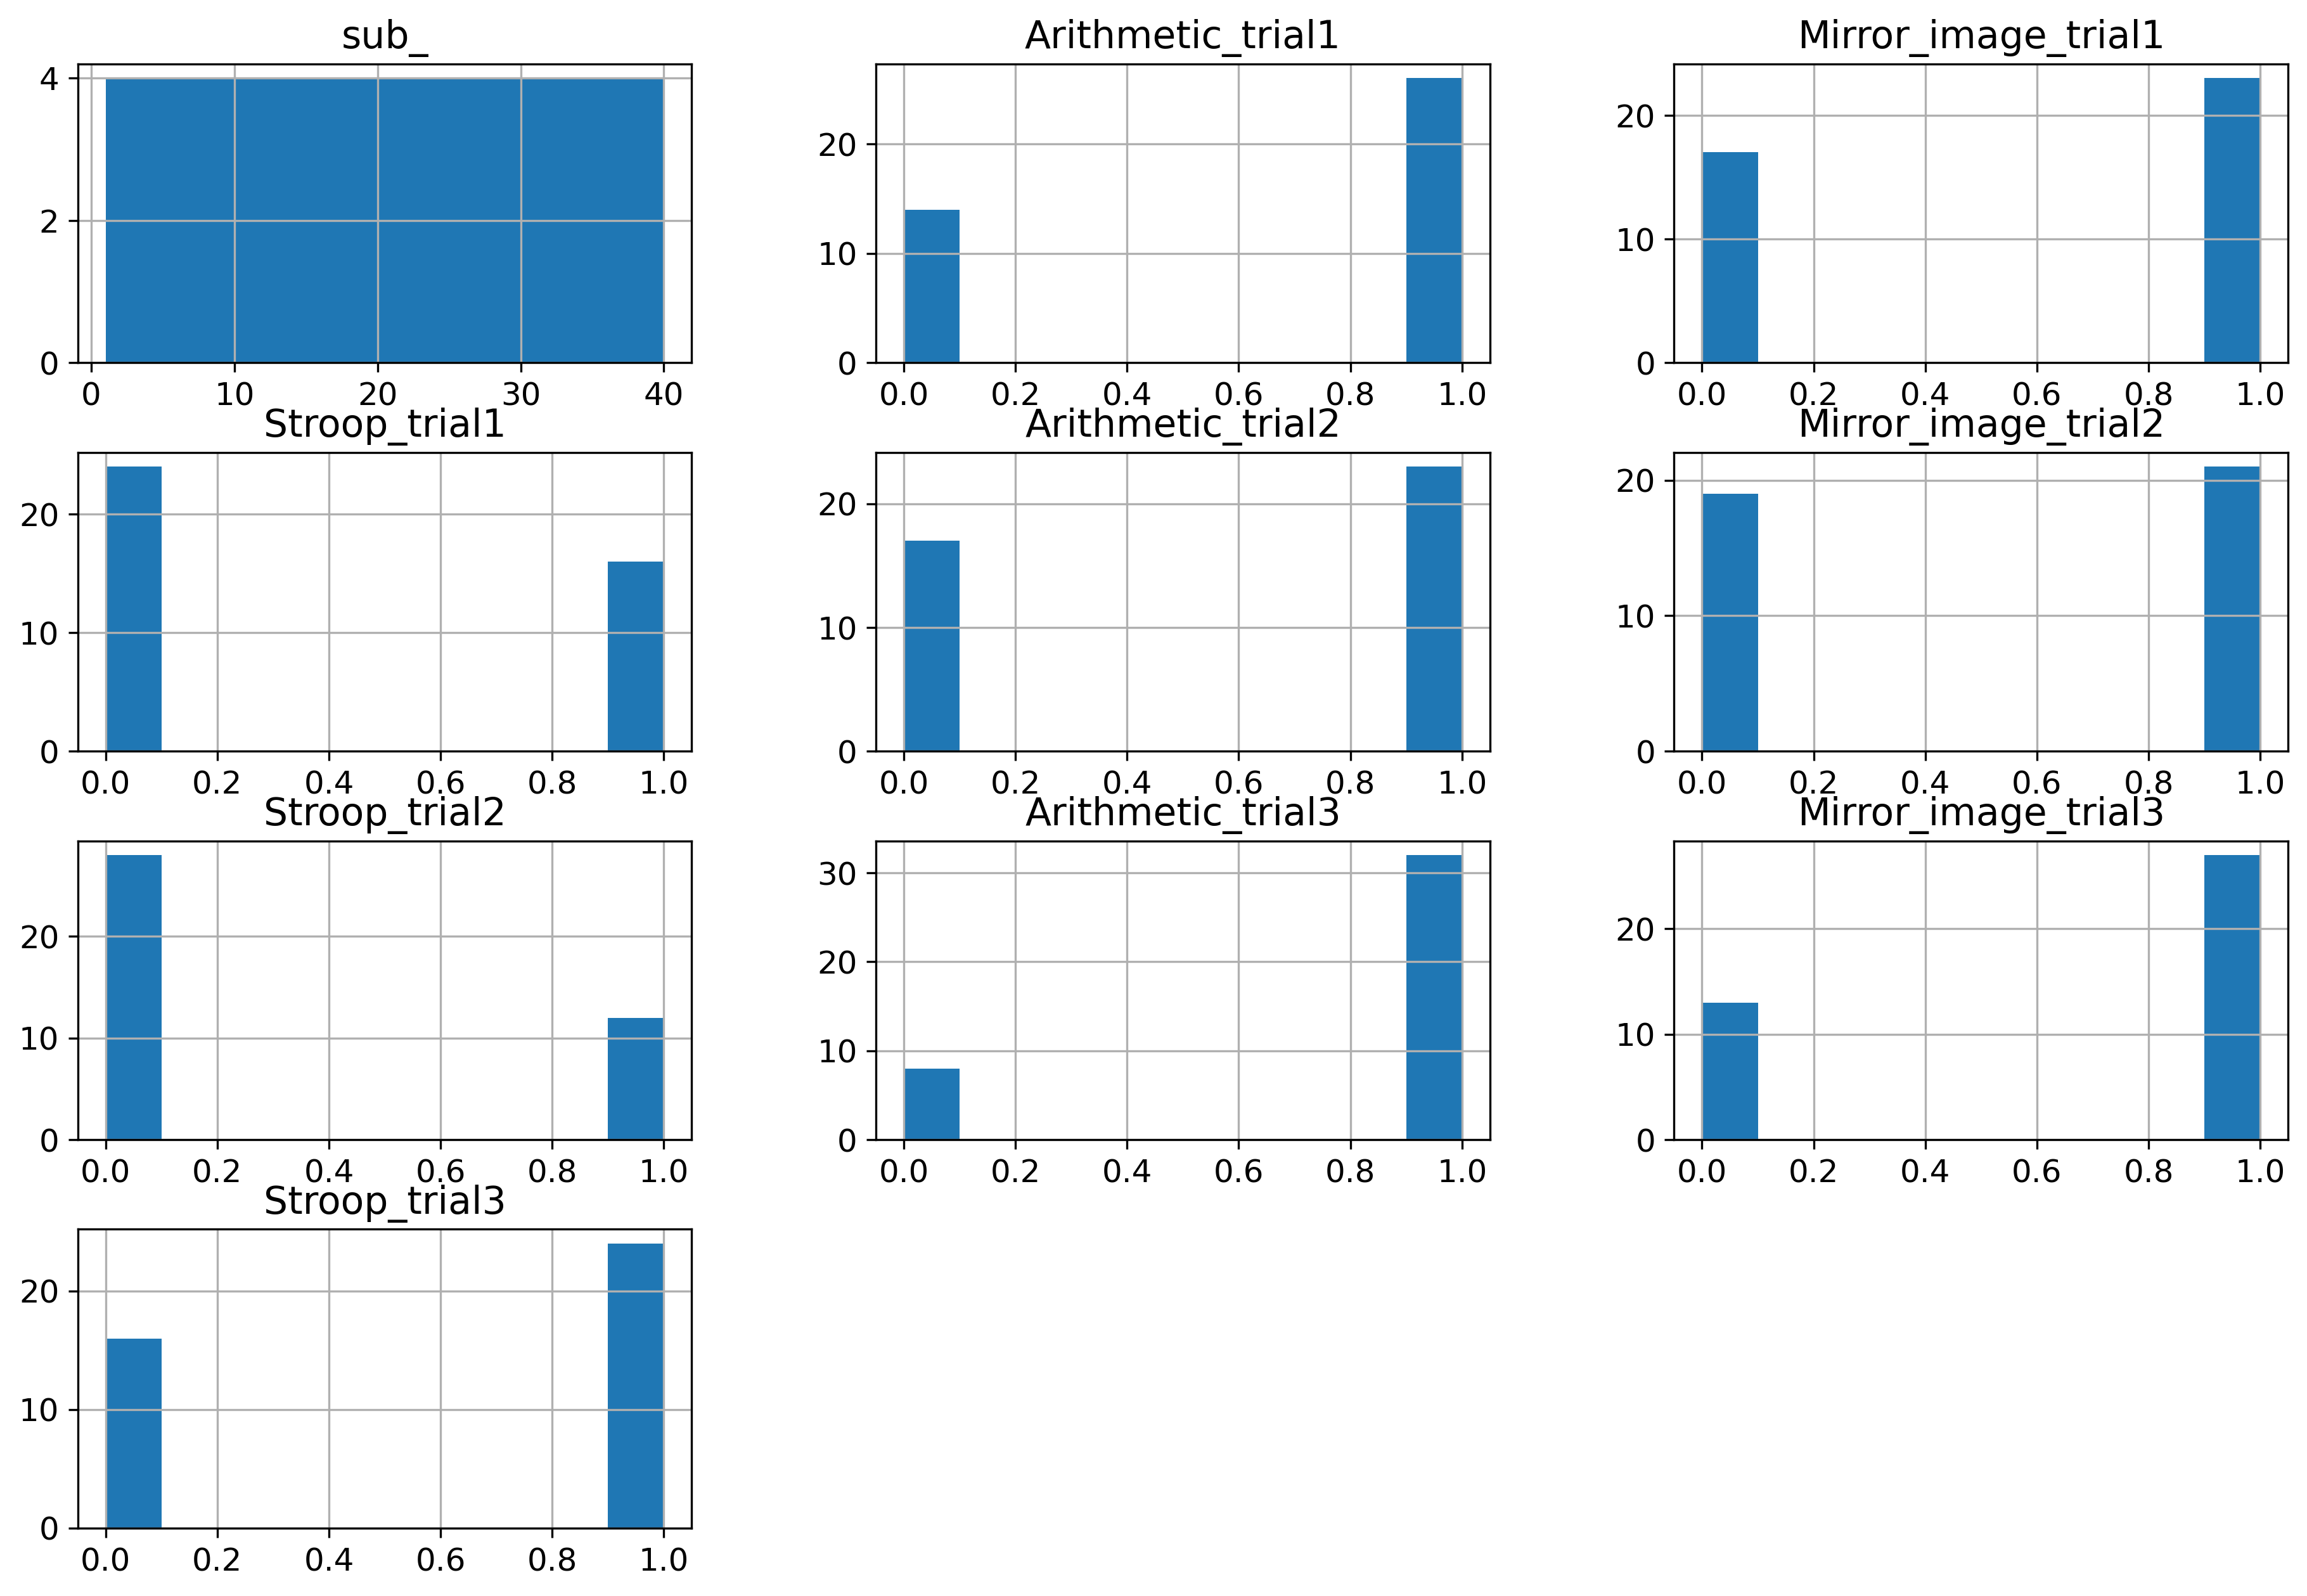

In [6]:
# create labels: 0 - relaxed, 1 - stressed
COLUMNS_TO_RENAME = {
    'Subject No.': 'sub_',
    'Trial_1': 'Arithmetic_trial1',
    'Unnamed: 2': 'Mirror_image_trial1',
    'Unnamed: 3': 'Stroop_trial1',
    'Trial_2': 'Arithmetic_trial2',
    'Unnamed: 5': 'Mirror_image_trial2',
    'Unnamed: 6': 'Stroop_trial2',
    'Trial_3': 'Arithmetic_trial3',
    'Unnamed: 8': 'Mirror_image_trial3',
    'Unnamed: 9': 'Stroop_trial3'
}

def load_labels():
    '''
    Loads labels from the dataset and transforms the label values to binary values.

    Returns:
        ndarray: The labels.
    '''
    labels = pd.read_excel(LABELS_PATH)
    labels = labels.rename(columns=COLUMNS_TO_RENAME)
    labels = labels[1:]

    labels.iloc[:, 1:] = labels.iloc[:, 1:] >= 5
    labels = labels.astype("int")
    return labels

labels = load_labels()
plt.figure()
labels.hist(figsize=(15,10))
#print(labels)

In [7]:
# Match data files with the labels values
# file = eeg_dataset/filtered_data\Task_sub_no_trialno.mat
def get_label(path_file):

    # extract only file name from the path_file
    file = os.path.basename(path_file)

    # remove .mat extension
    file = file.split('.')[0]

    # split the file into data frame columns
    split_file = file.split('_')

    # extract line and column from data frame
    line = int(split_file[len(split_file) - 2]) - 1

    # special case for Mirror_image
    if (len(split_file) == 5):
        split_file[0] = split_file[0] + '_' + split_file[1]
    column_name = split_file[0] + "_" + split_file[len(split_file) - 1]

    return labels.iloc[line][str(column_name)]

# extract labels for each task, subject and trial
arithmetic_task_labels = [get_label(i) for i in arithmetic_task_files]
relax_labels = [0 for i in relax_files]
stroop_task_labels =  [get_label(i) for i in stroop_task_files]
mirror_image_task_labels =[get_label(i) for i in mirror_image_task_files]

#repeat the labels for the specified amount of epochs
arithmetic_task_labels = np.array(arithmetic_task_labels).repeat(no_repeat)
relax_labels = np.array(relax_labels).repeat(no_repeat)
stroop_task_labels = np.array(stroop_task_labels).repeat(no_repeat)
mirror_image_task_labels = np.array(mirror_image_task_labels).repeat(no_repeat)

label_array = np.concatenate((arithmetic_task_labels, relax_labels, stroop_task_labels, mirror_image_task_labels))
print(label_array.shape)
#d = {'files': arithmetic_task_files, 'labels': arithmetic_task_labels}
#df = pd.DataFrame(data=d)
#print(df)

(5280,)


##### Split dataset in train set, validation set and testing set

In [8]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.

    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None,
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
            X = torch.as_tensor(X[None, ...])
        return X, y


def scale(X):
    """Standard scaling of data along the last dimention.

    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.

    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X *1000 / np.std(X, axis=1, keepdims=True)

In [9]:
from torch.utils.data import DataLoader, ConcatDataset
# - Create a data loader for the training dataset
x, x_test, y, y_test = train_test_split(data_array, label_array, test_size=0.3, shuffle=True, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.20, shuffle=True, random_state=42)

# Create dataloaders
train_batch_size = 16  # Important hyperparameter
valid_batch_size = 16  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process


num_classes = 2
kernels = 1

input_channels = 32
print('X_train shape:', x_train.shape)

x_train = torch.Tensor(np.expand_dims(x_train, axis=1))
x_val = torch.Tensor(np.expand_dims(x_val, axis=1))
x_test = torch.Tensor(np.expand_dims(x_test, axis=1))

#print(x_train.type())
train_set = EpochsDataset(x_train, y_train)
valid_set = EpochsDataset(x_val, y_val)
test_set = EpochsDataset(x_test, y_test)

print('X_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print('Number of examples in each set:')
print(f'Training: {len(train_set)}')
print(f'Validation: {len(valid_set)}')
print(f'Test: {len(test_set)}')

loader_train = DataLoader(
    train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_set, batch_size=valid_batch_size, shuffle=True, num_workers=num_workers)
loader_test = DataLoader(
    test_set, batch_size=valid_batch_size, shuffle=True, num_workers=num_workers)


X_train shape: (2956, 32, 640)
X_train shape: torch.Size([2956, 1, 32, 640])
y_train shape: (2956,)
2956 train samples
1584 test samples
Number of examples in each set:
Training: 2956
Validation: 740
Test: 1584


# Building EEG Net

### Define the model, training it and test it

In [10]:
def plot_acc_and_loss(history, figsize=(10,4)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.title.set_text("Acc")
    ax1.set_xlabel("Epochs")
    l1 = ax1.plot(history["acc"], color="red", label='train')
    l2 = ax1.plot(history["val_acc"], color="blue", label='test')

    ax2.title.set_text("Loss")
    ax2.set_ylabel("Epochs")
    l3 = ax2.plot(history["loss"], color="red", label='train')
    l4 = ax2.plot(history["val_loss"], color="blue", label='test')

    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")

    plt.show()

In [11]:
# - Determine which advice to use for training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)

cuda


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, time
import torch.optim as optim
import pickle
from torch.cuda import amp

class Model(object):
    def __init__(self, model=None, lr=0.001):
        super(Model, self).__init__()
        self.model = model
        self.losses = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.scaler = amp.GradScaler()

    def fit(self, trainloader=None, validloader=None, epochs=1, monitor=None, only_print_finish_ep_num=False):
        doValid = False if validloader == None else True
        pre_ck_point = [float("inf"), 0.0, float("inf"), 0.0, 0] # loss, acc, val_loss, val_acc, epoch
        history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
        print('epoch \t train_loss \t val_loss \t train_acc \t val_acc')
        print('-------------------------------------------------------------------')
        for ep in range(1, epochs + 1):
            proc_start = time.time() # timer start
            if (not (ep ==1)):
                if not only_print_finish_ep_num:
                    print(f"Epoch {ep}/{epochs}")
                    print(f'{ep} \t {loss:0.4f} \t {val_loss:0.4f}  \t {acc:0.4f} \t {val_acc:0.4f} \t ')
            self.model.train()       # Train mode
            step = 1                 # Restart step
            for x_batch, y_batch in trainloader:
                self.optimizer.zero_grad()
                x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
                label_onehot = F.one_hot(y_batch, 2).float()

               # print("Pred, x_batch and y_batch for loses", pred.shape, x_batch.shape, y_batch.shape)
                #loss = self.losses(pred, label_onehot)
                with amp.autocast():
                      pred = self.model(x_batch)
                      loss = self.losses(pred, label_onehot)
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()

                functional.reset_net(self.model)
                #loss.backward(retain_graph=True)
                #self.optimizer.step()
                #self.optimizer.zero_grad()
                if (not (ep == 1)):
                    pbar = int(step * 30 / len(trainloader))
                    if not only_print_finish_ep_num:

                        print("\r{}/{} [{}{}]".format(
                            step, len(trainloader), ">" * pbar, " " * (30 - pbar)), end="")
                    step += 1
            loss, acc = self.evaluate(trainloader)   # Loss & Accuracy
            val_loss, val_acc = self.evaluate(validloader) if doValid else (0, 0)   # if have validation dataset, evaluate validation
            history["loss"] = np.append(history["loss"], loss)
            history["acc"] = np.append(history["acc"], acc)
            history["val_loss"] = np.append(history["val_loss"], val_loss)
            history["val_acc"] = np.append(history["val_acc"], val_acc)
            # Update checkpoint
            if self.__updateCheckpoint(monitor, pre_ck_point, [loss, acc, val_loss, val_acc, ep]):
                save_file_name = f"checkpoint_model_ep-{ep}.pt"
                self.save(save_file_name)
                pre_ck_point = [loss, acc, val_loss, val_acc, ep]
                history['lastest_model_path'] = save_file_name

            if only_print_finish_ep_num:
                print(f'{ep} \t {loss:0.4f} \t {val_loss:0.4f}  \t {acc:0.4f} \t {val_acc:0.4f} \t ')
        return history

    def evaluate(self, dataloader, testing = None):
        total, acc = 0, 0
        inference_speed = 0
        self.model.eval()           # Eval mode
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
            start_time = time.time()
            pred = self.model(x_batch)
            inference_time = time.time()
            inference_speed += (inference_time - start_time)
            label_onehot = F.one_hot(y_batch, 2).float()
            loss = self.losses(pred, label_onehot).item()
            total += y_batch.shape[0]     # Number of data
            acc += (torch.sum(pred.argmax(dim=1)==y_batch)).item()     # Sum the prediction that's correct
            functional.reset_net(self.model)
        acc /= total     # Accuracy = correct prediction / number of data
        inference_speed = inference_speed / total
        if not testing == None:
          print("Average inference time for a batch of size 16 is:", inference_speed)
        return (loss, acc)

    def predict(self, dataset):
          dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
          prediction = []
          truth = []
          self.model.eval()
          for x_batch, y_batch in dataloader:
              x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device)
              pred = self.model(x_batch).cpu()
              prediction = np.append(prediction, pred.argmax(dim=1).numpy())
              truth = np.append(truth, y_batch.cpu().numpy())
          return prediction, truth

    def save(self, filepath):
          torch.save(self.model, filepath)

    def load(cls, filepath):
        return cls(torch.load(filepath))

    def __updateCheckpoint(self, monitor, pre_ck_point, evaluation):
        if type(monitor) is int:
            return True if evaluation[4] % monitor == 0 else False
        elif type(monitor) is list:
            for _ in monitor:
                if not _ in ["loss", "acc", "val_loss", "val_acc"]:
                    raise Exception(f"\"{_}\" is not a valid monitor condition.")
                elif _ == "loss" and pre_ck_point[0] <= evaluation[0]:
                    return False # present epoch loss > history loss
                elif _ == "acc" and pre_ck_point[1] >= evaluation[1]:
                    return False # present epoch acc <= history acc
                elif _ == "val_loss" and pre_ck_point[2] <= evaluation[2]:
                    return False # present epoch val_loss > history val_loss
                elif _ == "val_acc" and pre_ck_point[3] >= evaluation[3]:
                    return False # present epoch val_acc < history val_acc
        return True

In [16]:
from spikingjelly.activation_based import neuron, functional, surrogate, layer
# define the network structure
class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.T = 10
        self.network = nn.Sequential(
            layer.Conv2d(1, 8, 5, 1),
            layer.BatchNorm2d(8, eps=1e-3),

            layer.Conv2d(8, 16, 5, 1),
            layer.BatchNorm2d(16, eps=1e-3),
            neuron.IFNode(surrogate_function=surrogate.ATan(), v_threshold =  0.6),
            layer.MaxPool2d(1, 4),
            layer.Dropout(0.5),

            layer.Conv2d(16, 16, 3, 1),
            layer.Conv2d(16, 32, 3, 1),
            layer.BatchNorm2d(32, eps=1e-3),
            neuron.IFNode(surrogate_function=surrogate.ATan(), v_threshold =  0.4),
            layer.MaxPool2d(1, 8),
            layer.Dropout(0.6),

            layer.Flatten(),
            layer.Linear(640, 2),
            #neuron.IFNode(surrogate_function=surrogate.ATan(), v_threshold =  0.2),
            #nn.ReLU()
        )

        functional.set_step_mode(self, step_mode='m')

    def forward(self,x):
       # print(x.shape)
        x_seq = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W] [N, 1, C, TS] -> [T, N, 1, C, TS]
        x_seq = self.network(x_seq)
        #print(x_seq.shape)
        fr = x_seq.mean(0)
        return fr
       # x = self.network(x)
       # return x

In [17]:
# define hyperparameters
Learning_Rate = 0.005

EPOCHS = 100
#del eegnet
# create the model
eegnet = SNN().to(device)

# load the model
#eegnet.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
print(eegnet)

# or train the model
model = Model(eegnet, lr=Learning_Rate)
history = model.fit(trainloader=loader_train, validloader=loader_valid, epochs=EPOCHS, monitor=["acc", "val_acc"])

# save the model and the history dict
torch.save(model.model.state_dict(), PATH)

with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history, f)
#history = pickle.load(open(HISTORY_PATH, 'rb'))


SNN(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), step_mode=m)
    (1): BatchNorm2d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), step_mode=m)
    (3): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (4): IFNode(
      v_threshold=0.6, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (5): MaxPool2d(kernel_size=1, stride=4, padding=0, dilation=1, ceil_mode=False, step_mode=m)
    (6): Dropout(p=0.5)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), step_mode=m)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), step_mode=m)
    (9): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True, step_mode=m)
    (10): IFNode(
      v_threshold=0.4, v_reset=0.0, detach_reset=False, step_mode=m, backend=

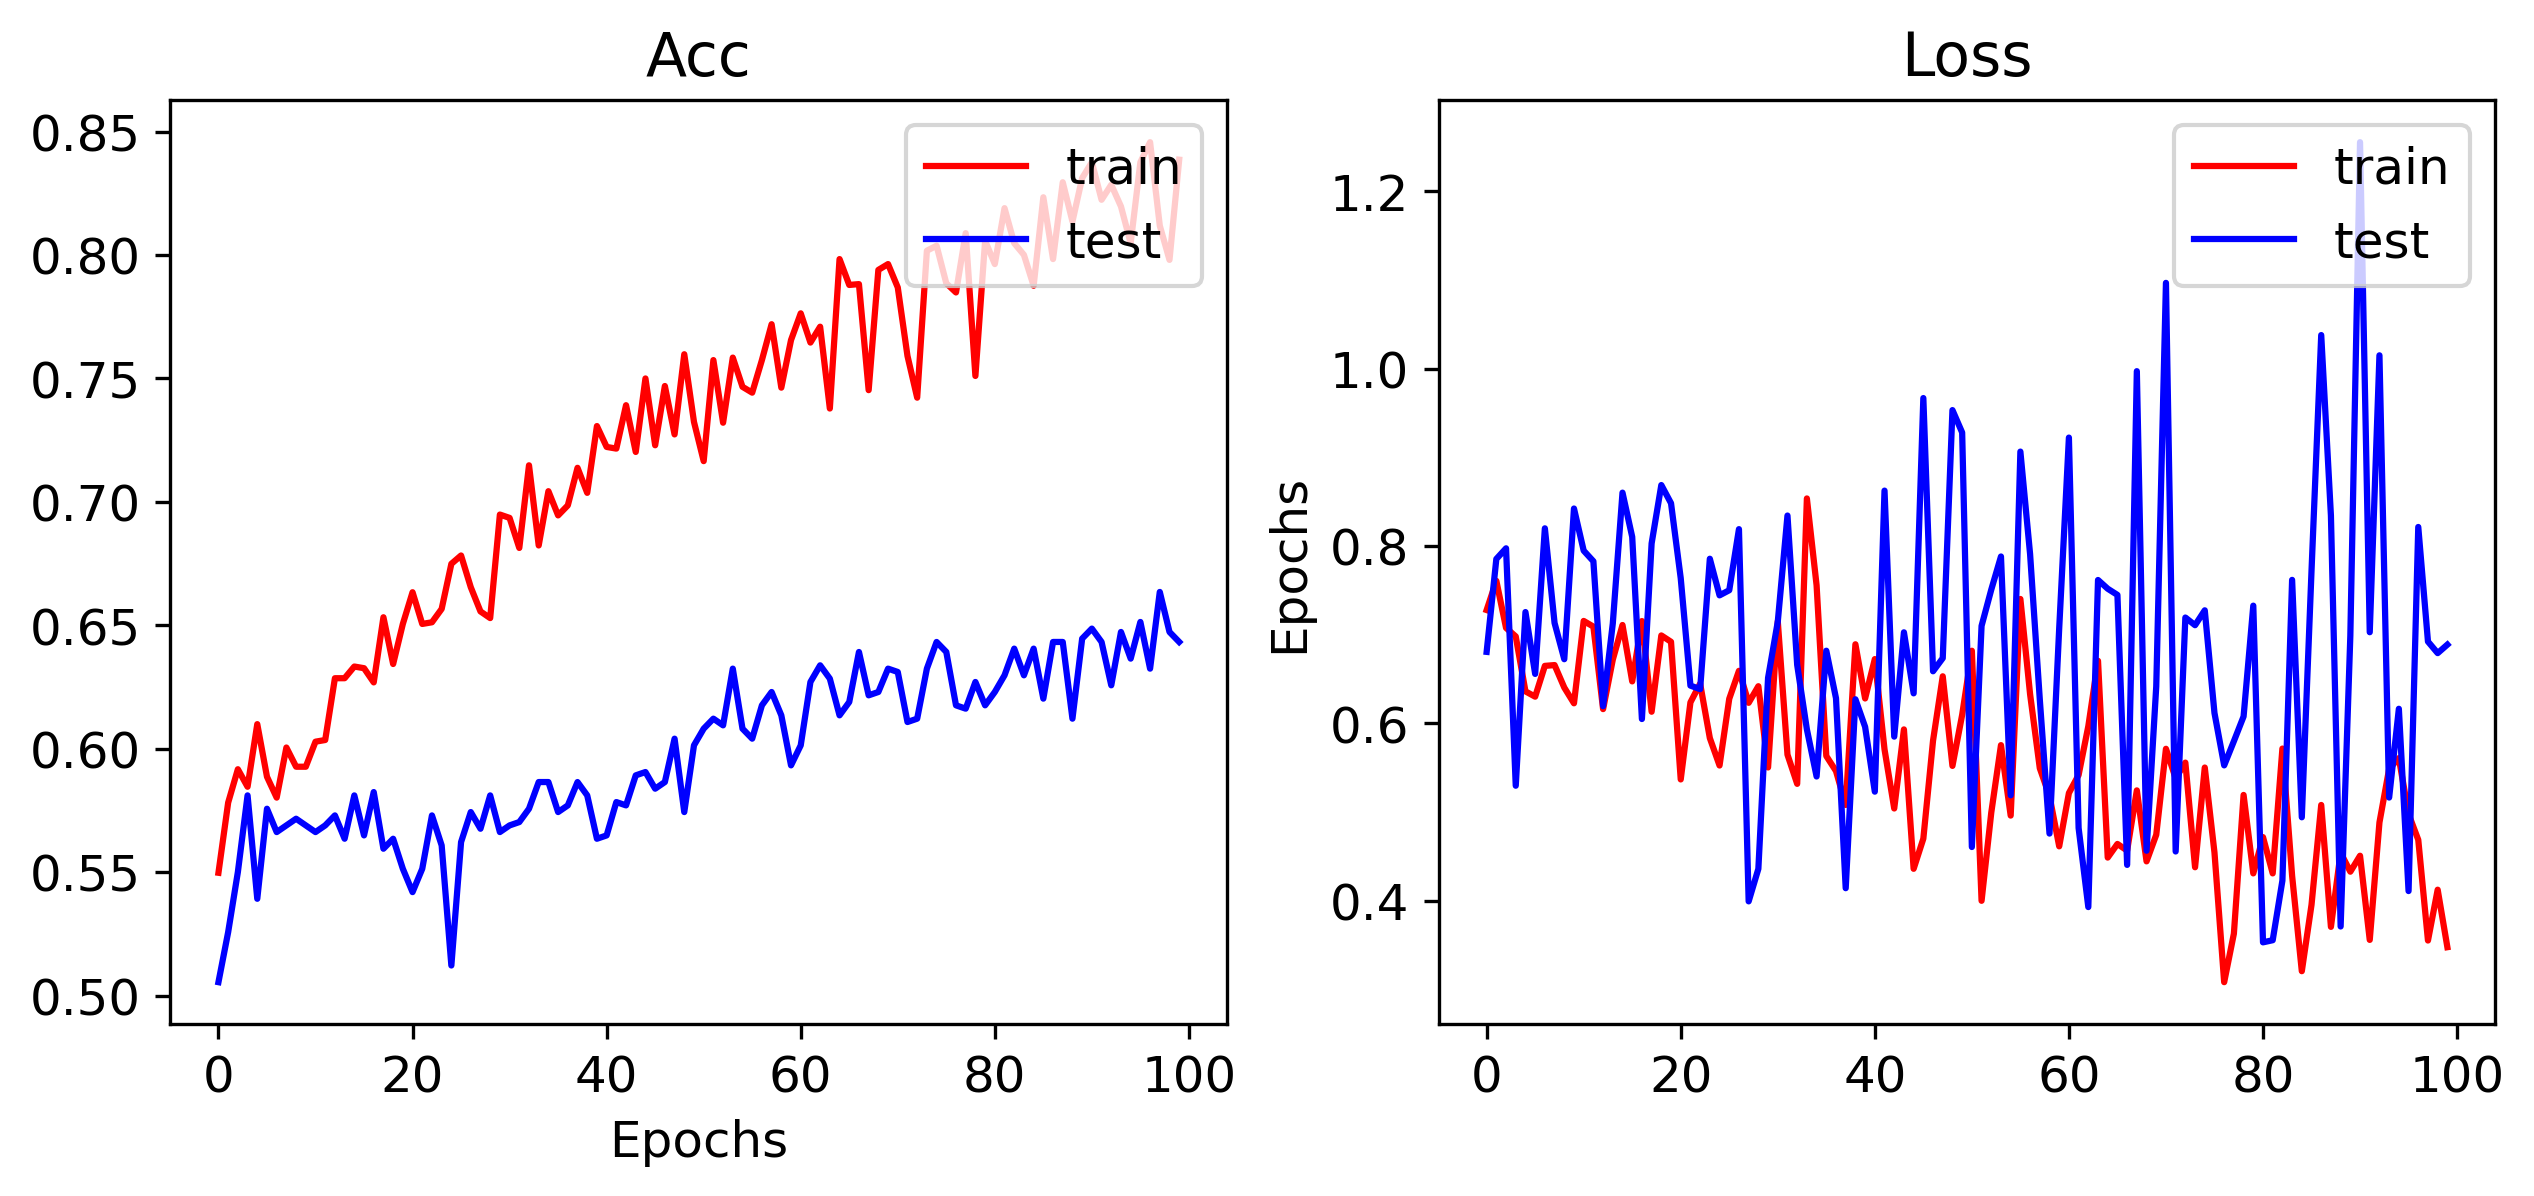

In [19]:
#plot the accuracy and the loss
plot_acc_and_loss(history=history)

In [20]:
print(f"Max valid accuracy is:", max(history['val_acc']))
print(f"Avg valid accuracy is:", sum(history['val_acc'])/len(history['val_acc']))

Max valid accuracy is: 0.6635135135135135
Avg valid accuracy is: 0.5981216216216214


In [21]:
# test the performance of the model
loss, acc = model.evaluate(loader_test, testing = True)

print(f"Test loss is:", loss)
print(f"Test accuracy is", acc)

Average inference time for a batch of size 16 is: 0.0002277166855455649
Test loss is: 0.5842322111129761
Test accuracy is 0.6553030303030303
